In [108]:
import numpy as np                     # numeric python lib

import matplotlib.image as mpimg       # reading images to numpy arrays
import matplotlib.pyplot as plt        # to plot any graph
import matplotlib.patches as mpatches  # to draw a circle at the mean contour

from skimage import measure             # to find shape contour
from skimage import io
import scipy.ndimage as ndi            # to determine shape centrality
from skimage.exposure import histogram

# matplotlib setup
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)

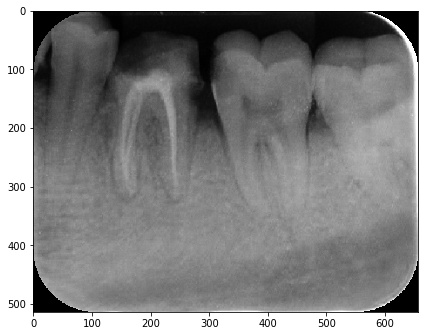

In [109]:
# reading an image file using matplotlib into a numpy array
# good ones: 11, 19, 23, 27, 48, 53, 78, 218
img = io.imread('Data/sample_data/images/10.jpg', as_gray = 'True' )
io.imshow(img)


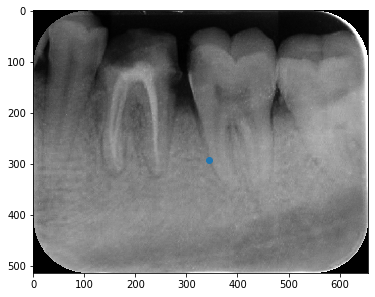

In [110]:
# using image processing module of scipy to find the center of the leaf
cy, cx  = ndi.center_of_mass(img)

plt.imshow(img, cmap='gray')  # show me the leaf
plt.scatter(cx, cy)           # show me its center
plt.show()

In [114]:
from skimage.feature import canny
from skimage import util

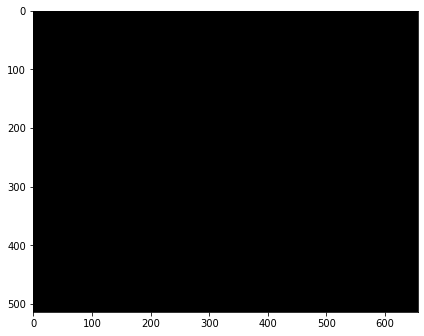

In [115]:
hist, hist_centers = histogram(img)
edges = canny(img/255.)
io.imshow(edges)

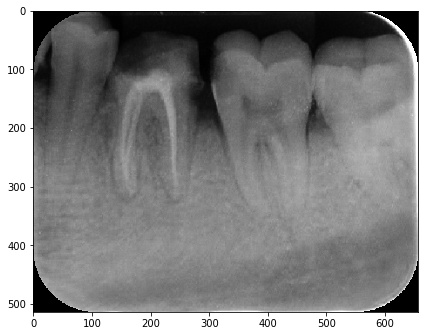

In [117]:
inverted_img = util.invert(img)
io.imshow(img)

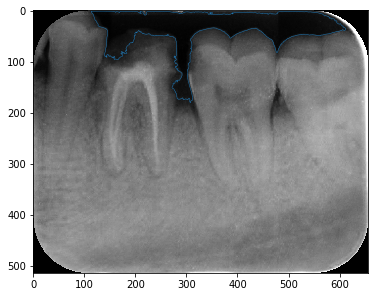

In [88]:
# scikit-learn imaging contour finding, returns a list of found edges
contours = measure.find_contours(img,.10)

# from which we choose the longest one
contour = max(contours, key=len)

# let us see the contour that we hopefully found
plt.plot(contour[::,1], contour[::,0], linewidth=0.5)  # (I will explain this [::,x] later)
plt.imshow(img, cmap='gray')
plt.show()

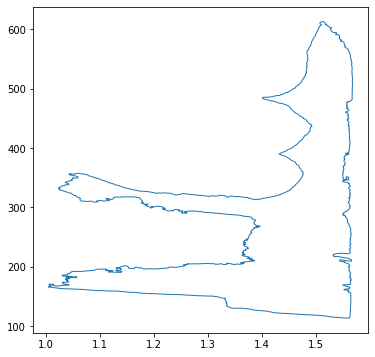

In [89]:
# cartesian to polar coordinates, just as the image shows above
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return [rho, phi]

# just calling the transformation on all pairs in the set
polar_contour = np.array([cart2pol(x, y) for x, y in contour])

# and plotting the result
plt.plot(polar_contour[::,1], polar_contour[::,0], linewidth=1)
plt.show()

In [90]:
contour[::,1] -= cx  # demean X
contour[::,0] -= cy  # demean Y

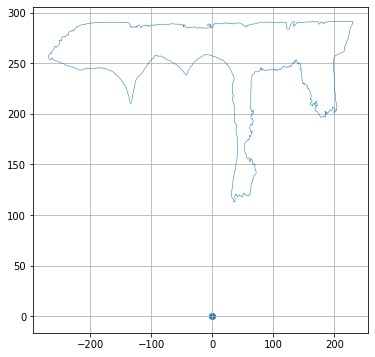

In [91]:
plt.plot(-contour[::,1], -contour[::,0], linewidth=0.5)
plt.grid()
plt.scatter(0, 0)
plt.show()

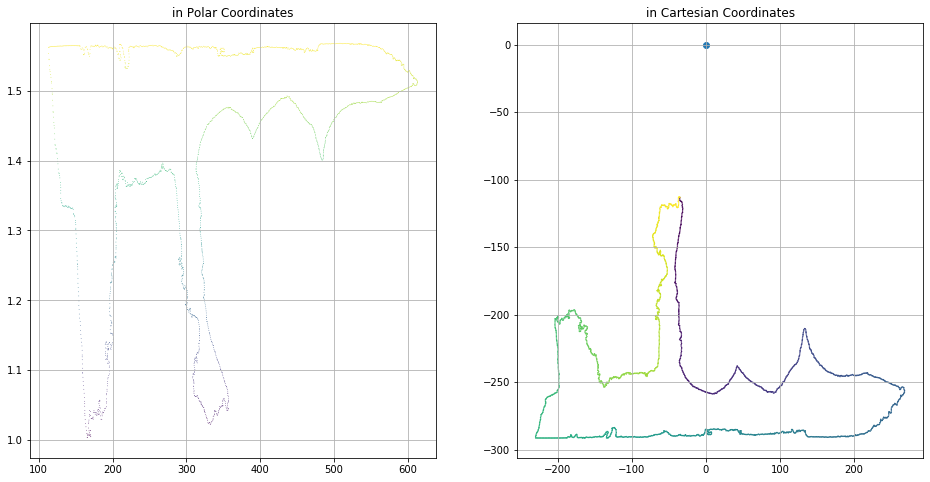

In [92]:
# and plotting the result
rcParams['figure.figsize'] = (16, 8)
plt.subplot(121)
plt.scatter(polar_contour[::,0], polar_contour[::,1], linewidth=0, s=.5, c=polar_contour[::,1])
plt.title('in Polar Coordinates')
plt.grid()
plt.subplot(122)
plt.scatter(contour[::,1],             # x axis is radians
            contour[::,0],             # y axis is distance from center
            linewidth=0, s=2,          # small points, w/o borders
            c=range(len(contour)))     # continuous coloring (so that plots match)
plt.scatter(0, 0)
plt.title('in Cartesian Coordinates')
plt.grid()
plt.show()

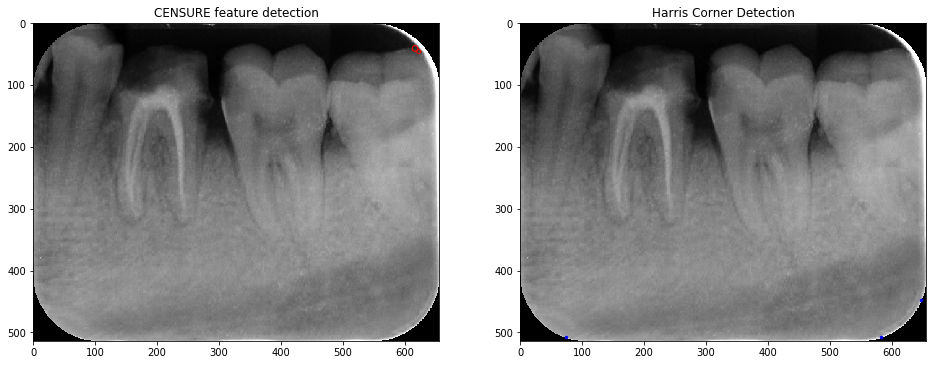

In [93]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks, CENSURE

detector = CENSURE()
detector.detect(img)

coords = corner_peaks(corner_harris(img), min_distance=5)
coords_subpix = corner_subpix(img, coords, window_size=13)

plt.subplot(121)
plt.title('CENSURE feature detection')
plt.imshow(img, cmap='gray')
plt.scatter(detector.keypoints[:, 1], detector.keypoints[:, 0],
              2 ** detector.scales, facecolors='none', edgecolors='r')

plt.subplot(122)
plt.title('Harris Corner Detection')
plt.imshow(img, cmap='gray')  # show me the leaf
plt.plot(coords[:, 1], coords[:, 0], '.b', markersize=5)
plt.show()

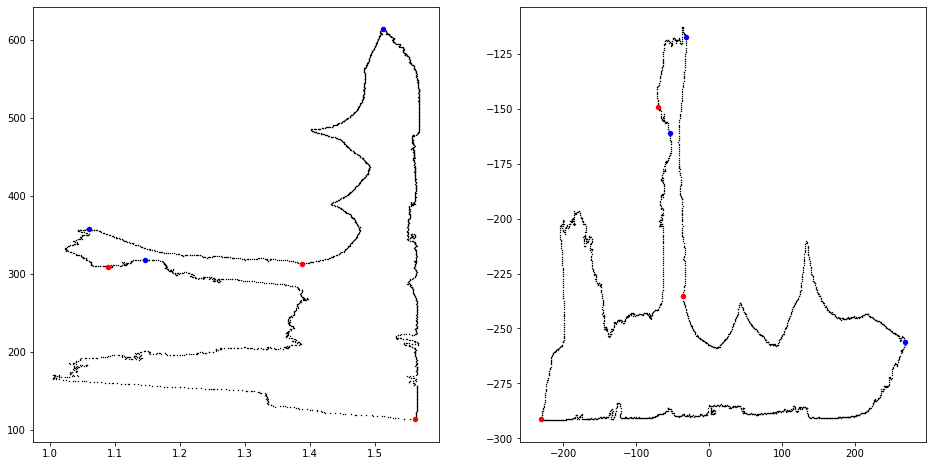

In [94]:
from scipy.signal import argrelextrema

# for local maxima
c_max_index = argrelextrema(polar_contour[::,0], np.greater, order=50)
c_min_index = argrelextrema(polar_contour[::,0], np.less, order=50)

plt.subplot(121)
plt.scatter(polar_contour[::,1], polar_contour[::,0], 
            linewidth=0, s=2, c='k')
plt.scatter(polar_contour[::,1][c_max_index], 
            polar_contour[::,0][c_max_index], 
            linewidth=0, s=30, c='b')
plt.scatter(polar_contour[::,1][c_min_index], 
            polar_contour[::,0][c_min_index], 
            linewidth=0, s=30, c='r')

plt.subplot(122)
plt.scatter(contour[::,1], contour[::,0], 
            linewidth=0, s=2, c='k')
plt.scatter(contour[::,1][c_max_index], 
            contour[::,0][c_max_index], 
            linewidth=0, s=30, c='b')
plt.scatter(contour[::,1][c_min_index], 
            contour[::,0][c_min_index], 
            linewidth=0, s=30, c='r')

plt.show()

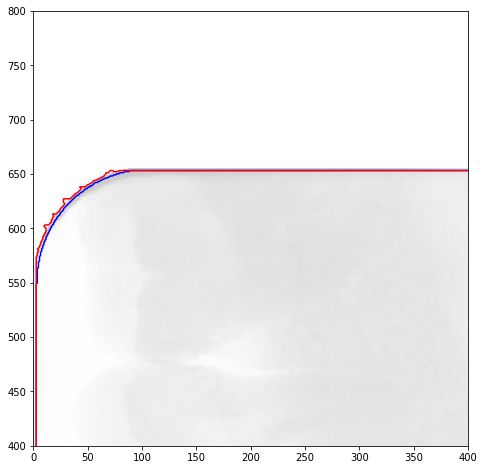

In [95]:
def cont(img):
    return max(measure.find_contours(img, .8), key=len)

# let us set the 'brush' to a 6x6 circle
struct = [[ 0., 0., 1., 1., 0., 0.],
          [ 0., 1., 1., 1., 1., 0.],  
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 0., 1., 1., 1., 1., 0.],
          [ 0., 0., 1., 1., 0., 0.]]

erosion = cont(ndi.morphology.binary_erosion(img, structure=struct).astype(img.dtype))
closing = cont(ndi.morphology.binary_closing(img, structure=struct).astype(img.dtype))
opening = cont(ndi.morphology.binary_opening(img, structure=struct).astype(img.dtype))
dilation = cont(ndi.morphology.binary_dilation(img, structure=struct).astype(img.dtype))

plt.imshow(img.T, cmap='Greys', alpha=.2)
plt.plot(erosion[::,0], erosion[::,1], c='b')
plt.plot(opening[::,0], opening[::,1], c='g')
plt.plot(closing[::,0], closing[::,1], c='r')
plt.plot(dilation[::,0], dilation[::,1], c='k')
#plt.xlim([220, 420])
#plt.ylim([250, 420])
plt.xlim([0, 400])
plt.ylim([400, 800])
plt.show()